# financial analysis and predict LSTM

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time 


# Introduction.
We have stock data of four big company. I try to choose different sectors because of figure out pandemic and turkish economic conditions.And finally compare TRY and USD values.

* thy;
Turkish Airlines the leader of the aviation industry in Turkey
* garan;
Garanti Bank is the largest bank in Turkey
* migros;
the most valuable company for retail sector
a* selsan;
the company's largest Turkey company in the defense industry.
You can reach other stock market datasets in Yahoo for your kernels !

# finally If you liked my work, please upvote this kernel since it will keep me motivated for my other studies.Thank you for your suggestions and advice
* Content
* Load data and missing value
* Visualization
* Stock Market techniques
* Moving Average
* Bollinger Bands
* MacD
* Volalite
* USD/ TRY comparison in a stock
* Build LSTM

Load data and missing value:

In [6]:
aselsan = pd.read_csv("ASELS.IS (1).csv")
aselsan.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-14,9.065,9.065,8.345,8.54,8.492481,42021734.0
1,2019-10-15,8.700,8.750,8.590,8.63,8.581981,33555048.0
2,2019-10-16,8.540,8.540,8.380,8.46,8.412927,30679518.0
3,2019-10-17,8.440,8.555,8.400,8.47,8.422871,39035758.0
4,2019-10-18,8.950,8.995,8.840,8.93,8.880311,53236982.0


In [7]:
migros = pd.read_csv("MGROS.IS.csv")
migros["stock_name"]="migros"
migros_copy = migros.copy()
#only two row null. I want to fill because of the graph and predictions.
#simply we take average nearest rows
print("migros stock null values:\n", migros[migros.isnull().any(axis=1)])

thy = pd.read_csv("THYAO.IS.csv")
thy["stock_name"] = "thy"
thy_copy = thy.copy()
print("thy stock null values:\n", thy[thy.isnull().any(axis=1)])

aselsan = pd.read_csv("ASELS.IS (1).csv")
aselsan["stock_name"] = "aselsan"
aselsan_copy = aselsan.copy()
print("aselsan stock null values:\n", aselsan[aselsan.isnull().any(axis=1)])

garan = pd.read_csv("GARAN.IS.csv")
garan["stock_name"]= "garan"
garan_copy = garan.copy()
print("garan stock null values:\n", garan[garan.isnull().any(axis=1)])

datalist=[migros, thy, aselsan, garan]
all_data = pd.concat(datalist,axis=1, ignore_index=True)

migros stock null values:
            Date  Open  High  Low  Close  Adj Close  Volume stock_name
190  2020-07-16   NaN   NaN  NaN    NaN        NaN     NaN     migros
232  2020-09-16   NaN   NaN  NaN    NaN        NaN     NaN     migros
thy stock null values:
            Date  Open  High  Low  Close  Adj Close  Volume stock_name
192  2020-07-20   NaN   NaN  NaN    NaN        NaN     NaN        thy
234  2020-09-18   NaN   NaN  NaN    NaN        NaN     NaN        thy
aselsan stock null values:
            Date  Open  High  Low  Close  Adj Close  Volume stock_name
234  2020-09-18   NaN   NaN  NaN    NaN        NaN     NaN    aselsan
garan stock null values:
            Date  Open  High  Low  Close  Adj Close  Volume stock_name
192  2020-07-20   NaN   NaN  NaN    NaN        NaN     NaN      garan
234  2020-09-18   NaN   NaN  NaN    NaN        NaN     NaN      garan


In [8]:
def fillmissing_value(stocks,copy):
    #number of total rows which has null value
    nullrownumber = stocks.shape[0] - stocks.dropna().shape[0]
    
    for i in range(nullrownumber):
        null_data = stocks[stocks.isnull().any(axis=1)]
        getindex=null_data.index
        stocks.drop(["Date", "stock_name"], axis=1, inplace = True)
        
        ortalama1 = stocks.iloc[getindex[0]-1]
        ortalama2 = stocks.iloc[getindex[0]+1]
        ortalama = stocks.iloc[getindex[0]]
        ortalama = (ortalama1+ortalama2)/2
        ortalama[:4]=ortalama[:4].astype("float16")
        stocks.iloc[getindex[0]]=stocks.iloc[getindex[0]].fillna(ortalama)
        stocks["Date"] = copy["Date"]
        stocks["stock_name"] = copy["stock_name"]
        stocks["Volume"]=stocks["Volume"].astype("float")
        
datalist=[migros, thy,garan, aselsan]
dataliststr=["migros", "thy","garan", "aselsan"]
datalist_copy=[migros_copy, thy_copy,garan_copy, aselsan_copy]

for i in range(len(datalist)):
    fillmissing_value(datalist[i],datalist_copy[i])
    
for i in range(len(datalist)):
    null_data = datalist[i].isnull().any().sum()
    print("{} dataset has: {} null value".format(dataliststr[i] ,null_data))

migros dataset has: 0 null value
thy dataset has: 0 null value
garan dataset has: 0 null value
aselsan dataset has: 0 null value


In [9]:
print(aselsan.describe())

             Open        High         Low       Close   Adj Close  \
count  252.000000  252.000000  252.000000  252.000000  252.000000   
mean    13.586064   13.822564   13.374211   13.590501   13.558250   
std      3.031660    3.109261    2.966714    3.026840    3.039556   
min      8.440000    8.540000    8.345000    8.460000    8.412927   
25%     10.875000   11.272500   10.702500   11.015000   10.982423   
50%     13.675000   13.855000   13.410000   13.710000   13.669453   
75%     16.292500   16.537501   16.100000   16.282501   16.250448   
max     19.320000   19.860001   18.540001   19.459999   19.459999   

             Volume  
count  2.520000e+02  
mean   5.785669e+07  
std    3.824472e+07  
min    0.000000e+00  
25%    3.223856e+07  
50%    4.774408e+07  
75%    6.863176e+07  
max    2.953460e+08  


In [10]:
print(aselsan.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        252 non-null    float64
 1   High        252 non-null    float64
 2   Low         252 non-null    float64
 3   Close       252 non-null    float64
 4   Adj Close   252 non-null    float64
 5   Volume      252 non-null    float64
 6   Date        252 non-null    object 
 7   stock_name  252 non-null    object 
dtypes: float64(6), object(2)
memory usage: 15.9+ KB
None


In [11]:
print("{} means weekdays in a one year.".format(aselsan.shape[0]))

252 means weekdays in a one year.


# visualizations

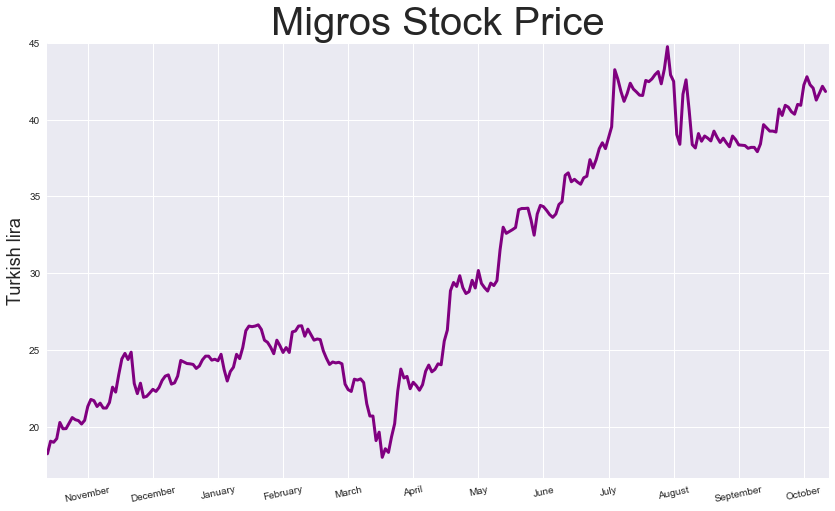

In [12]:

plt.style.use("seaborn")
plt.figure(figsize=(14,8))
plt.plot(migros["Close"], color="purple", linewidth=3)
plt.title("Migros Stock Price", fontsize=40)
months=["November","December","January","February","March","April","May","June","July","August","September","October"]
plt.xticks(np.arange(0,252,21)+13,labels=months,rotation=12)  # Set text labels and properties.
plt.xlim(left=0, right=252) #252 equals number of rows
plt.ylim(top=45) 
plt.ylabel("Turkish lira", fontsize=18)
plt.show()

# Quick not: The first corona virüs case was announced on 11 March in turkey. You can observe all of stock market graphs.

No wonder markets collapse!

(0.0, 252.0)

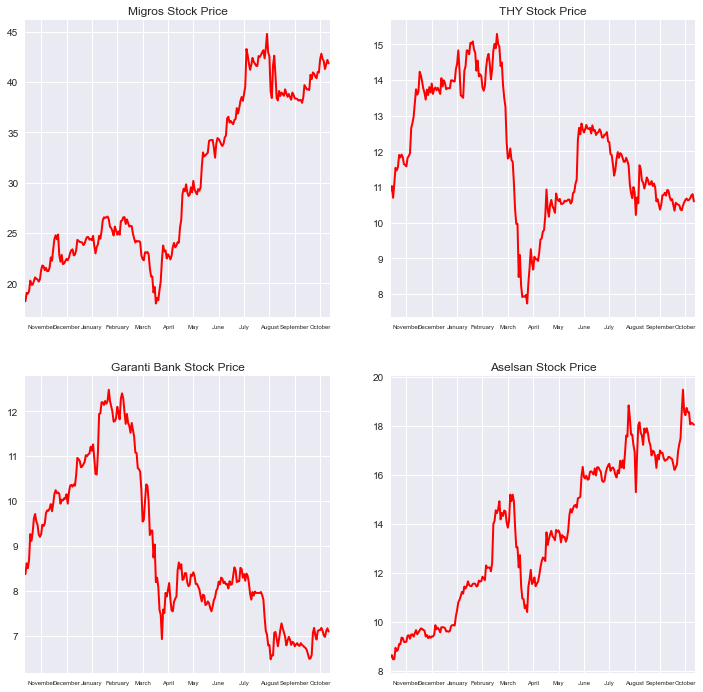

In [13]:
plt.style.use("seaborn")
fig, axs = plt.subplots(2, 2,figsize=(12,12))

axs[0, 0].plot(migros["Close"], color="Red", linewidth=2)
axs[0, 0].set_title("Migros Stock Price")
axs[0, 0].set_xticks(np.arange(0,252,21)+13)
axs[0, 0].set_xticklabels([i for i in months],fontsize=6)
axs[0, 0].set_xlim(left=0, right=252)

axs[0, 1].plot(thy["Close"], color="red", linewidth=2)
axs[0, 1].set_title("THY Stock Price")
axs[0, 1].set_xticks(np.arange(0,252,21)+13)
axs[0, 1].set_xticklabels([i for i in months],fontsize=6)
axs[0, 1].set_xlim(left=0, right=252)


axs[1, 0].plot(garan["Close"], color="red", linewidth=2)
axs[1, 0].set_title("Garanti Bank Stock Price")
axs[1, 0].set_xticks(np.arange(0,252,21)+13)
axs[1, 0].set_xticklabels([i for i in months],fontsize=6)
axs[1, 0].set_xlim(left=0, right=252)


axs[1, 1].plot(aselsan["Close"], color="red", linewidth=2)
axs[1, 1].set_title("Aselsan Stock Price")
axs[1, 1].set_xticks(np.arange(0,252,21)+13)
axs[1, 1].set_xticklabels([i for i in months],fontsize=6)
axs[1, 1].set_xlim(left=0, right=252)

# lets we analyze annual return on stocks 14/October/2019---14/October/2020

In [14]:
datalist=[migros, thy,garan, aselsan]
for company in datalist:
    first_price = round(company["Close"].iloc[0],2)
    last_price =  round(company["Close"].iloc[-1],2)
    print("*" * 25)
    print("first Close price: {} and last Close price: {}".format(first_price,last_price))
    annual_return = ((last_price-first_price) * 100 ) / (first_price)
    print("{} annual return is: %{:.2f}".format(company["stock_name"][0], annual_return))

*************************
first Close price: 18.24 and last Close price: 41.84
migros annual return is: %129.39
*************************
first Close price: 10.9 and last Close price: 10.6
thy annual return is: %-2.75
*************************
first Close price: 8.37 and last Close price: 7.09
garan annual return is: %-15.29
*************************
first Close price: 8.54 and last Close price: 18.03
aselsan annual return is: %111.12


* we can say that , pandemic and economic conditions mostly affected banking and aviation sectors
* on the other hand pandemic conditions affected positively retail sector.(Migros) People did not reduce food spending.

In [16]:
migros["Volume"] = migros["Volume"].astype({"Volume":"float"})
#(x-Xmin)/(Xmax- Xmin)
column = migros["Volume"]
max_value = column.max()
min_value = column.min()

migros["Volume"]=((migros["Volume"]-min_value)/(max_value -min_value))*15
#I use min-max scaler than I multiple 15 to make the graph clearer

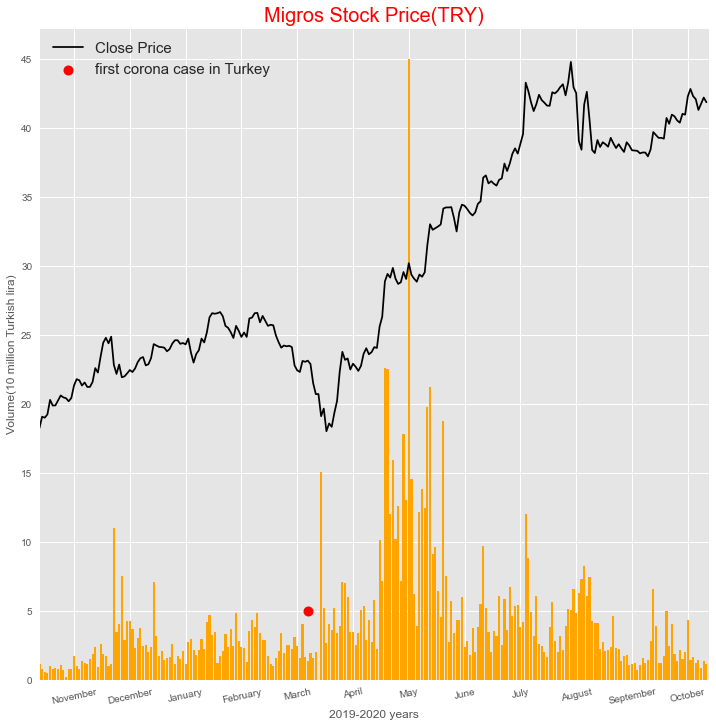

In [17]:
plt.figure(figsize=(12,12))
plt.style.use("ggplot")
plt.title("Migros Stock Price(TRY)", color ="red", fontsize=20)
plt.bar(migros["Date"], migros["Volume"]*3,  color="orange")
plt.plot(migros["Close"], color="black", label="Close Price")
plt.xticks(np.arange(0,252,21)+13,labels=months,rotation=12)
plt.yticks(np.arange(0,50,5))
plt.xlim(left=0, right=252) #252 equals number of rows
plt.ylabel("Volume(10 million Turkish lira)")
plt.xlabel("2019-2020 years")

x = 101
y = 5
plt.scatter(x, y, color='red',linewidths=3, label="first corona case in Turkey")
plt.legend(prop={'size': 15})
plt.show()

After stock volume normalization process, I multiple "15" and normalization values because of that plotting more understandable graphs.

In [18]:
describe = migros_copy["Volume"].describe()
print(describe)
print("*"*20)
print("Mean Volume of stock; 3,813,146 million TRY")

count    2.500000e+02
mean     3.813146e+06
std      4.209976e+06
min      0.000000e+00
25%      1.565536e+06
50%      2.565804e+06
75%      4.391157e+06
max      4.079791e+07
Name: Volume, dtype: float64
********************
Mean Volume of stock; 3,813,146 million TRY


# Stock Market techniques
* Moving Average
* Bollinger Bands
* MacD
* Volatility
* The main things of moving averages is firstly that they smooth the data and thus provide a clearer visual picture of the current trend and secondly, that m.a. signals can give a precise answer as to what the trend is.

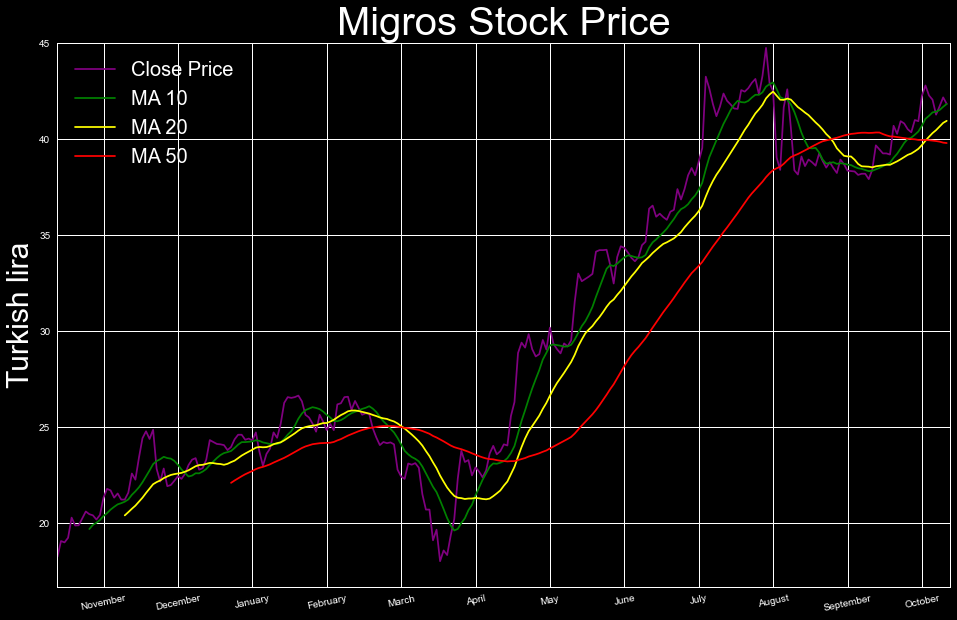

In [19]:
moving_average_day = [10, 20, 50]
datalist=[migros, thy,garan, aselsan]
for ma in moving_average_day:
    for company in datalist:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()


plt.style.use("dark_background")
plt.figure(figsize=(16,10))
plt.plot(migros["Close"], color="purple", label="Close Price")
plt.plot(migros["MA for 10 days"], color="green", label="MA 10")
plt.plot(migros["MA for 20 days"], color="yellow", label="MA 20")
plt.plot(migros["MA for 50 days"], color="red", label="MA 50")
plt.title("Migros Stock Price", fontsize=40)
months=["November","December","January","February","March","April","May","June","July","August","September","October"]
plt.xticks(np.arange(0,252,21)+13,labels=months,rotation=12)  # Set text labels and properties.
plt.xlim(left=0, right=252) #252 equals number of rows
plt.ylim(top=45) 
plt.ylabel("Turkish lira", fontsize=30)
plt.legend(prop={'size': 20})

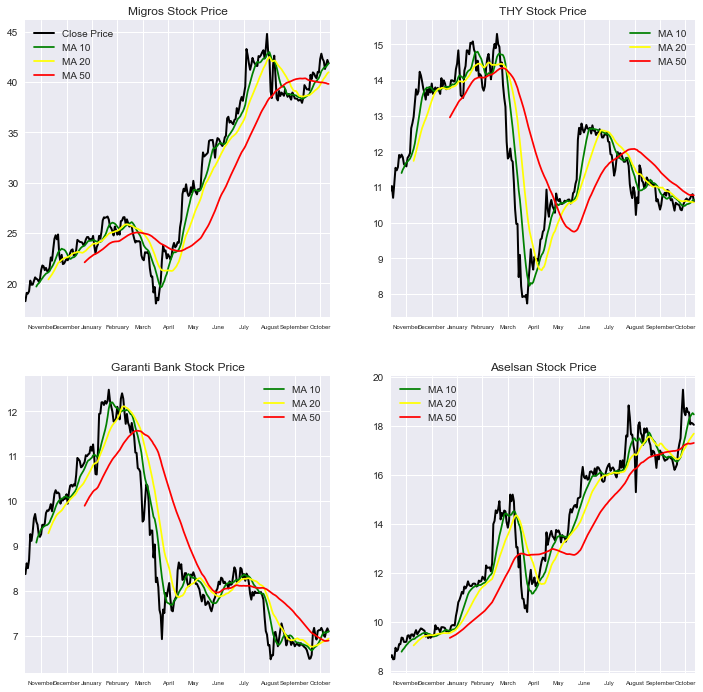

In [20]:
plt.style.use("seaborn")
fig, axs = plt.subplots(2, 2,figsize=(12,12))

axs[0, 0].plot(migros["Close"], color="black", linewidth=2, label="Close Price")
axs[0, 0].plot(migros["MA for 10 days"], color="green", label="MA 10")
axs[0, 0].plot(migros["MA for 20 days"], color="yellow", label="MA 20")
axs[0, 0].plot(migros["MA for 50 days"], color="red", label="MA 50")
axs[0, 0].set_title("Migros Stock Price")
axs[0, 0].set_xticks(np.arange(0,252,21)+13)
axs[0, 0].set_xticklabels([i for i in months],fontsize=6)
axs[0, 0].set_xlim(left=0, right=252)
axs[0, 0].legend(prop={'size': 10})

axs[0, 1].plot(thy["Close"], color="black", linewidth=2)
axs[0, 1].plot(thy["MA for 10 days"], color="green", label="MA 10")
axs[0, 1].plot(thy["MA for 20 days"], color="yellow", label="MA 20")
axs[0, 1].plot(thy["MA for 50 days"], color="red", label="MA 50")
axs[0, 1].set_title("THY Stock Price")
axs[0, 1].set_xticks(np.arange(0,252,21)+13)
axs[0, 1].set_xticklabels([i for i in months],fontsize=6)
axs[0, 1].set_xlim(left=0, right=252)
axs[0, 1].legend(prop={'size': 10})


axs[1, 0].plot(garan["Close"], color="black", linewidth=2)
axs[1, 0].plot(garan["MA for 10 days"], color="green", label="MA 10")
axs[1, 0].plot(garan["MA for 20 days"], color="yellow", label="MA 20")
axs[1, 0].plot(garan["MA for 50 days"], color="red", label="MA 50")
axs[1, 0].set_title("Garanti Bank Stock Price")
axs[1, 0].set_xticks(np.arange(0,252,21)+13)
axs[1, 0].set_xticklabels([i for i in months],fontsize=6)
axs[1, 0].set_xlim(left=0, right=252)
axs[1, 0].legend(prop={'size': 10})


axs[1, 1].plot(aselsan["Close"], color="black", linewidth=2)
axs[1, 1].plot(aselsan["MA for 10 days"], color="green", label="MA 10")
axs[1, 1].plot(aselsan["MA for 20 days"], color="yellow", label="MA 20")
axs[1, 1].plot(aselsan["MA for 50 days"], color="red", label="MA 50")
axs[1, 1].set_title("Aselsan Stock Price")
axs[1, 1].set_xticks(np.arange(0,252,21)+13)
axs[1, 1].set_xticklabels([i for i in months],fontsize=6)
axs[1, 1].set_xlim(left=0, right=252)
axs[1, 1].legend(prop={'size': 10})

# Bollinger Bands consist of 3 calculations:

* The first or middle Bollinger Band is a moving average of the closing price(20 day)
* The second line is the upper Bollinger Band.MOV20+(2*20Standard Deviation of Close)
* The third line is the lower Bollinger Band.MOV20-(2*20Standard Deviation of Close)

Text(0, 0.5, 'Turkish lira')

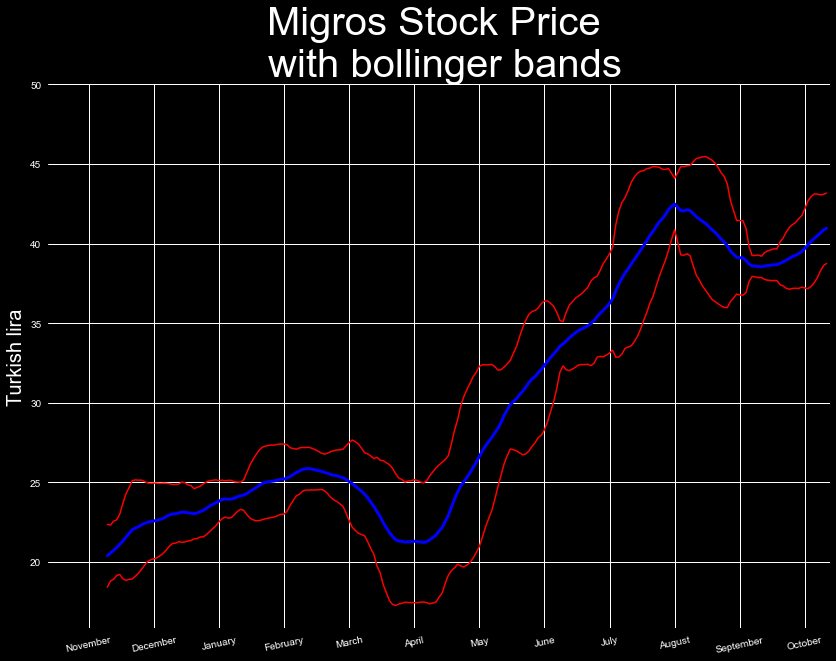

In [21]:
plt.style.use("dark_background")
plt.figure(figsize=(14,10))
plt.plot(migros["MA for 20 days"], color="blue", linewidth=3)

#üst band
üstband = migros['Close'].rolling(20).std()
plt.plot((migros["MA for 20 days"]+üstband*2), color="red",linewidth=1.5)

#alt band
altband = migros['Close'].rolling(20).std()
plt.plot((migros["MA for 20 days"]-altband*2), color="red",linewidth=1.5)
plt.title("Migros Stock Price \n with bollinger bands", fontsize=40)
months=["November","December","January","February","March","April","May","June","July","August","September","October"]
plt.xticks(np.arange(0,252,21)+13,labels=months,rotation=12)  # Set text labels and properties.
plt.xlim(left=0, right=252) #252 equals number of rows
plt.ylim(top=50) 
plt.ylabel("Turkish lira", fontsize=20)

* One of the primary benefits of MACD is that it incorporates aspects of both momentum and trend in one indicator. As a trend-following indicator, it will not be wrong for very long. The use of moving averages ensures that the indicator will eventually follow the movements of the underlying security
* The Formula for MACD Is: MACD=12-Period EMA − 26-Period EMA
* Macd signal line is: 9 period EMA(mof MACD)

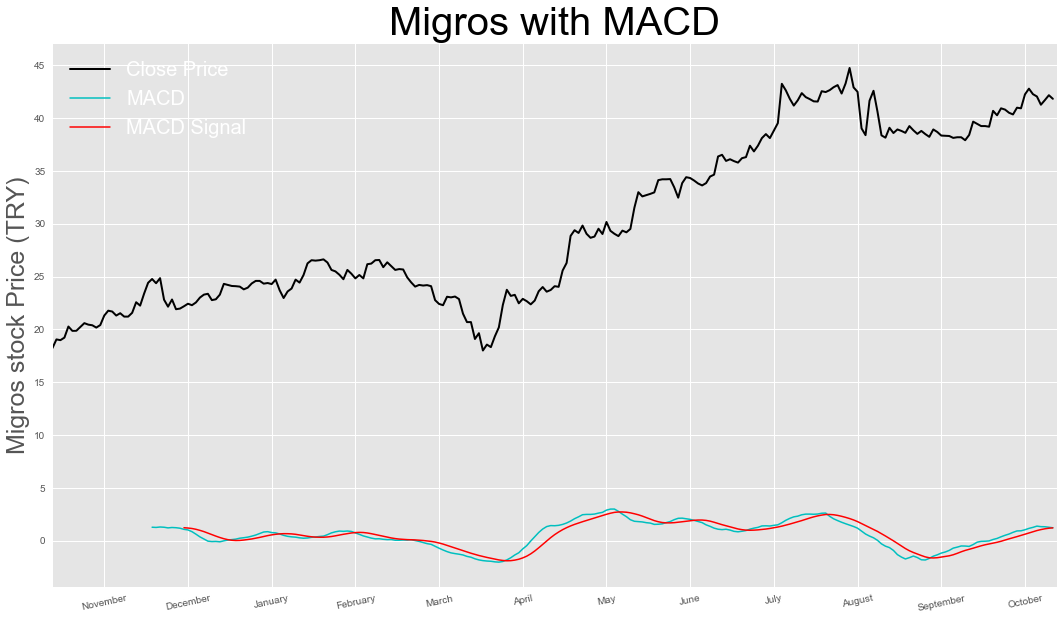

In [22]:
Ema12 = migros["Close"].rolling(12).mean()
Ema26 = migros["Close"].rolling(26).mean()
MACD = Ema12 - Ema26
migros["MACD"] = MACD
MacdSignal = migros["MACD"].rolling(9).mean()
migros["MacdSignal"] = MacdSignal

plt.style.use("ggplot")
plt.figure(figsize=(18,10))
plt.plot(migros["Close"], color="black", linewidth=2, label="Close Price")
plt.plot(migros["MACD"], color="c", linewidth=1.5, label = "MACD")
plt.plot(migros["MacdSignal"], color="red", linewidth=1.5, label = "MACD Signal")
plt.title("Migros with MACD", fontsize=40,color="black")
months=["November","December","January","February","March","April","May","June","July","August","September","October"]
plt.xticks(np.arange(0,252,21)+13,labels=months,rotation=12)  # Set text labels and properties.
plt.yticks(np.arange(0,50 ,5))
plt.xlim(left=0, right=252) #252 equals number of rows
plt.legend(prop={'size': 20})
plt.ylabel("Migros stock Price (TRY)", fontsize=25)
plt.show()

* Volatility is a statistical measure of the dispersion of returns for a given security or market index. In most cases, the higher the volatility, the riskier the security

* Daily price volatility;

In [23]:
garan["volalite(kuruş)"] = garan["Close"]-garan["Open"]
garan["volalite"]= 100*garan["volalite(kuruş)"]/garan["Open"]
garan["volalite"].describe()

count    252.000000
mean      -0.224899
std        2.039237
min       -8.223684
25%       -1.253422
50%       -0.241400
75%        0.693028
max        8.409091
Name: volalite, dtype: float64

# Usd/Try price
* Dollar has vital importance for Turkey. There are many reasons about that.

* Many Turkish firms has high “open position” in dollars.
* Imported products are bought in dollars
* Low domestic production

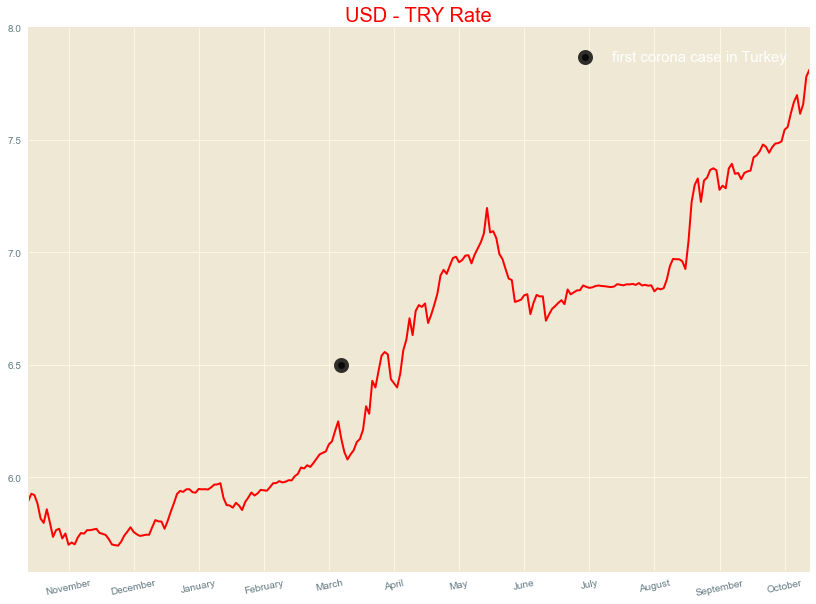

In [24]:
usdtry = pd.read_csv("USDTRYX.csv")

plt.figure(figsize=(14,10))
plt.style.use("Solarize_Light2")
plt.plot(usdtry["Close"], color="red")
plt.title("USD - TRY Rate", fontsize=20, color="red")
months=["November","December","January","February","March","April","May","June","July","August","September","October"]
plt.xticks(np.arange(0,252,21)+13,labels=months,rotation=12)  
plt.xlim(left=0, right=252) #252 equals number of rows
plt.grid(True)
plt.ylim(top=8)

x = 101
y = 6.5
plt.scatter(x, y, color='black',linewidths=8, label="first corona case in Turkey", alpha=0.8)
plt.legend(prop={'size': 15}, borderpad=1, shadow=True, facecolor="red")
plt.show()
#print(usdtry["Close"])

* okey we plot garanti bank stock with Dollar and Try values in same
* firstly we have to concat (dollar and Garanti Bank) datasets

In [25]:
annualy_difference_usd = usdtry["Close"][252] - usdtry["Close"][0]
print("annualy difference (USD) {}".format(annualy_difference_usd))
annualy_difference_rate = (100 * annualy_difference_usd)/usdtry["Close"][0] 
print("TRY value  %{:.2f} dropped in a year".format(annualy_difference_rate))

annualy difference (USD) 1.9170299999999996
TRY value  %32.52 dropped in a year


# Turkish lira is among the top 3 depreciating countries against the dollar in this period.

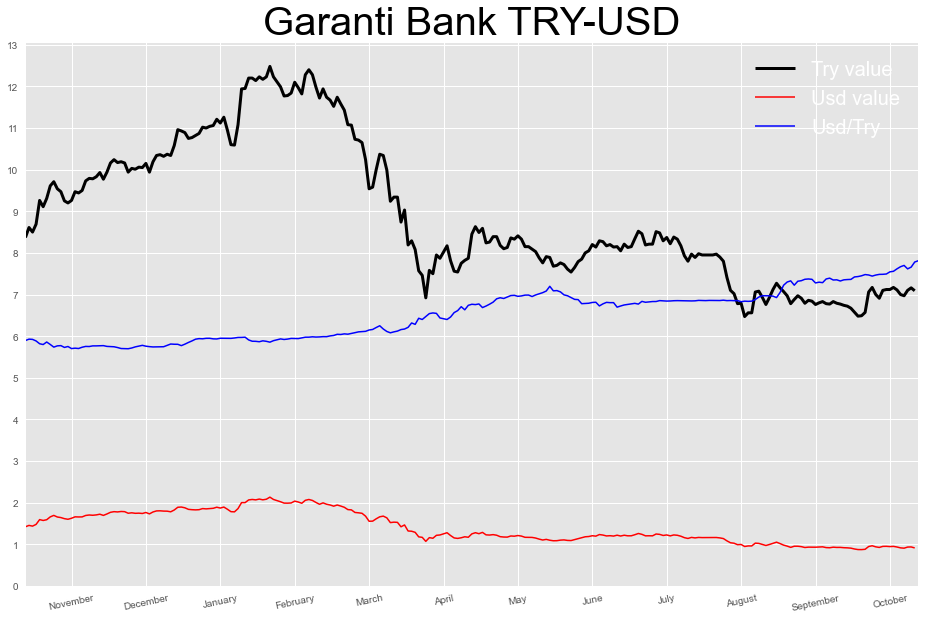

In [26]:
usdtry.rename(columns={"Close":"usdclose"}, inplace =True)
garan = pd.concat([garan,usdtry["usdclose"]],axis=1)
garan["usdvalue"] = garan["Close"]/garan["usdclose"]


plt.style.use("ggplot")
plt.figure(figsize=(16,10))

plt.plot(garan["Close"], color="black", linewidth=3, label="Try value")
plt.plot(garan["usdvalue"], color="red", linewidth=1.5, label="Usd value")
plt.plot(garan["usdclose"], color="blue", linewidth=1.5, label="Usd/Try")

plt.title("Garanti Bank TRY-USD", fontsize=40,color="black")
months=["November","December","January","February","March","April","May","June","July","August","September","October"]
plt.xticks(np.arange(0,252,21)+13,labels=months,rotation=12)  # Set text labels and properties.
plt.yticks(np.arange(0, 14, 1))
plt.xlim(left=0, right=252) #252 equals number of rows
plt.legend(prop={'size': 20}, facecolor="orange")
plt.show()

# On the graph we observe that, TL's depreciation did not bring investment to the stock !

# Build Model:

In [27]:
data = migros.filter(['Close'])
data_mig = data.values.astype("float32")
print(data_mig.shape)

#scaler for keras model
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_mig_price = scaler.fit_transform(np.array(data_mig).reshape(-1,1))
print(data_mig_price.shape)

train_size = int(len(data_mig_price) * 0.8)  
test_size = int(len(data_mig_price) * 0.2)

train_data = data_mig_price[0:train_size,:]
test_data =data_mig_price[train_size-20:len(data_mig_price),:]

print("train data len: {}, test data len : {}".format(len(train_data), len(test_data)))

(252, 1)
(252, 1)
train data len: 201, test data len : 71


In [28]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)
print("X_test shape:",X_test.shape)
print("ytest shape:",ytest.shape)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

X_train shape: (180, 20)
y_train shape: (180,)
X_test shape: (50, 20)
ytest shape: (50,)


In [29]:
model = Sequential()

model.add(LSTM(64,input_dim=1,return_sequences=True))


model.add(LSTM(128,return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(64))
model.add(Dropout(0.3))

model.add(Dense(1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mean_squared_error', optimizer='Adam')
print ('compilation time : ', time.time() - start)

model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=25,
    validation_split=0.05)

model.summary()


compilation time :  0.010063886642456055
Epoch 1/25
3/3 [==============================] - 1s 284ms/step - loss: 0.1482 - val_loss: 0.1260
Epoch 2/25
3/3 [==============================] - 0s 21ms/step - loss: 0.0261 - val_loss: 0.0614
Epoch 3/25
3/3 [==============================] - 0s 21ms/step - loss: 0.0346 - val_loss: 0.0096
Epoch 4/25
3/3 [==============================] - 0s 17ms/step - loss: 0.0137 - val_loss: 0.0871
Epoch 5/25
3/3 [==============================] - 0s 22ms/step - loss: 0.0196 - val_loss: 0.0702
Epoch 6/25
3/3 [==============================] - 0s 18ms/step - loss: 0.0157 - val_loss: 0.0163
Epoch 7/25
3/3 [==============================] - 0s 23ms/step - loss: 0.0115 - val_loss: 0.0014
Epoch 8/25
3/3 [==============================] - 0s 23ms/step - loss: 0.0119 - val_loss: 0.0057
Epoch 9/25
3/3 [==============================] - 0s 21ms/step - loss: 0.0099 - val_loss: 0.0013
Epoch 10/25
3/3 [==============================] - 0s 21ms/step - loss: 0.0083 - val_

In [30]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),
          epochs=100,batch_size=64)

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

Epoch 1/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0076 - val_loss: 0.0030
Epoch 2/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0067 - val_loss: 0.0027
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0066 - val_loss: 0.0085
Epoch 4/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0069 - val_loss: 0.0133
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0070 - val_loss: 0.0049
Epoch 6/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0061 - val_loss: 0.0029
Epoch 7/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0071 - val_loss: 0.0036
Epoch 8/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0054 - val_loss: 0.0165
Epoch 9/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0074 - val_loss: 0.0064
Epoch 10/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0070 - val_loss: 0.0028
Epoch 11/100
3/3 [=

Epoch 84/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0042 - val_loss: 0.0067
Epoch 85/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 86/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 87/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 88/100
3/3 [==============================] - 0s 27ms/step - loss: 0.0038 - val_loss: 0.0065
Epoch 89/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 90/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 91/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 92/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 93/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 94/1

In [31]:
import math
from sklearn.metrics import mean_squared_error

#rmse : root mean square error
train_data_rmse = math.sqrt(mean_squared_error(y_train,train_predict))
print("train data rmse: {}".format(train_data_rmse))
test_data_rmse= math.sqrt(mean_squared_error(ytest,test_predict))
print("test data rmse: {}".format(test_data_rmse))

train data rmse: 28.503126541771692
test data rmse: 39.79670016157119


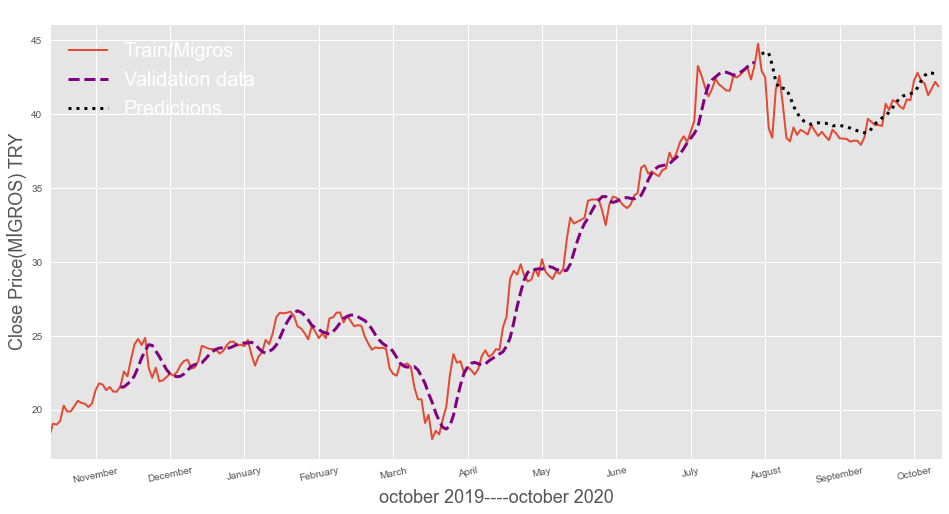

In [32]:
plt.figure(figsize=(16,8))
step_size=20

train = np.empty_like(data_mig_price)
train[:, :] = np.nan
train[step_size:len(train_predict)+step_size, :] = train_predict

test = np.empty_like(data_mig_price)
test[:, :] = np.nan
test[len(train_predict)+(step_size)+1:len(data_mig_price)-1, :] = test_predict

plt.plot(migros["Close"])
plt.plot(train, color ="purple", linestyle="dashed", linewidth=3)
plt.plot(test, color="black", linestyle="dotted",linewidth=3)
plt.title('For Migros Stock price predict')
plt.xlabel('october 2019----october 2020', fontsize=18)
plt.ylabel('Close Price(MİGROS) TRY', fontsize=18)
plt.xticks(np.arange(0,252,21)+13,labels=months,rotation=12)  
plt.xlim(left=0, right=252) #252 equals number of rows
plt.legend(['Train/Migros', 'Validation data', 'Predictions'], prop={'size': 20})
plt.show()